In [13]:
import pickle
with open("vonMisesData_100neurons_extralong.p", "rb") as input_file:
    [NumNeurons, NeuronParameters, WorldParameters, Neurons, 
         NumTrajectories, TrajStartPos, RatRadialSpeed, TrajLength, SpikeRasters] = pickle.load(input_file)

In [14]:
# All imports here...
import numpy as np

import time

from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# display place field coverage of a particular environment
sns.set(rc={'figure.figsize': (18, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [15]:
def BinSpikeRasters(Rasters, BinWidth=0.25, NBins=0) :
    # Rasters is a list of ndarrays, where each array contains spike times for a neuron
    if (NBins == 0) :
        b = 0.0;
        for spk_ts in Rasters :
            if (len(spk_ts) > 0) :
                b = max(b, (spk_ts[-1] / BinWidth))
        NBins = np.int(np.ceil(b))
    BinnedRasters = np.zeros((NBins, len(Rasters)))
    
    for k, spk_ts in enumerate(Rasters) :
        for s in spk_ts :
            BinnedRasters[np.int(s/BinWidth), k] += 1
    return BinnedRasters

In [16]:

t0 = time.time();
# Train model with first environment
NTrain = 900
NTest = 100
BinWidth = 0.25 # 250 ms bins
NBins = np.int(TrajLength / BinWidth)
TrainingData = []
for w in range(WorldParameters['NEnv']) :
    TrainingData.append([])
    for k in range(NTrain) :
        TrainingData[w].append(BinSpikeRasters(SpikeRasters[w][k], BinWidth=BinWidth, NBins=NBins))
t1 = time.time();
print("Time elapsed for binning: ", t1-t0)




Time elapsed for binning:  15.622438907623291


In [17]:
StackedTrainingData = []
TrainingSequenceLengths = []
for w in range(WorldParameters['NEnv']) :
    StackedTrainingData.append(np.vstack(TrainingData[w]))
    TrainingSequenceLengths.append(np.zeros(NTrain, dtype=int))
    for idx,l in enumerate(TrainingData[w]) :
        (TrainingSequenceLengths[w][idx], ncols) = l.shape


In [18]:
# Compare different numbers of states
DifferentStateNumberModels = []
NStates = [8,10,20,30]
t0 = time.time();
for n in NStates :
    model = hmm.PoissonHMM(n_components=n, n_iter=200, tol=1e-4, init_params='smc')
    t_init = np.zeros((n,n))
    for i in range(n):
        for j in range(n) :
            if (i > j) :
                t_init[i][j] = 0.5**(np.abs(i-j))
            else :
                t_init[i][j] = 0.1**(np.abs(i-j))
    from hmmlearn.utils import normalize
    t_init = normalize(t_init, axis=1)
    model.transmat_ = t_init
    DifferentStateNumberModels.append(model)




for idx in range(len(NStates)) :
    t1 = time.time();
    # Build an HMM instance and set parameters
    DifferentStateNumberModels[idx].fit(StackedTrainingData[0], lengths=TrainingSequenceLengths[0])
    
    t2 = time.time();
    print(t2-t1)
t3 = time.time();
print(t3-t0) # ~120 s total

70.77875995635986
29.69406819343567
108.31180906295776
192.60882210731506
401.40406584739685


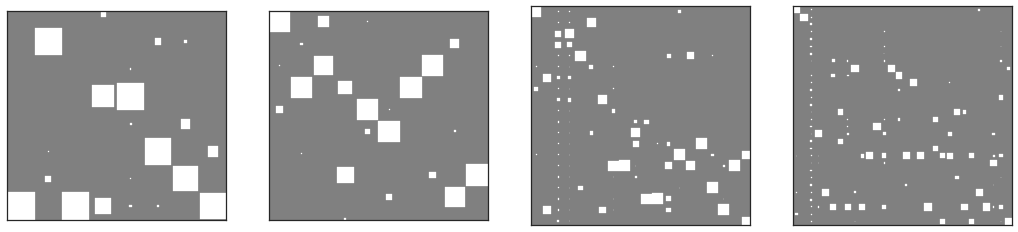

In [19]:
from hinton import hinton
f, axarr = plt.subplots(1,len(NStates))
for idx in range(len(NStates)) :
    plt.sca(axarr[idx])
    hinton(DifferentStateNumberModels[idx].transmat_)



/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


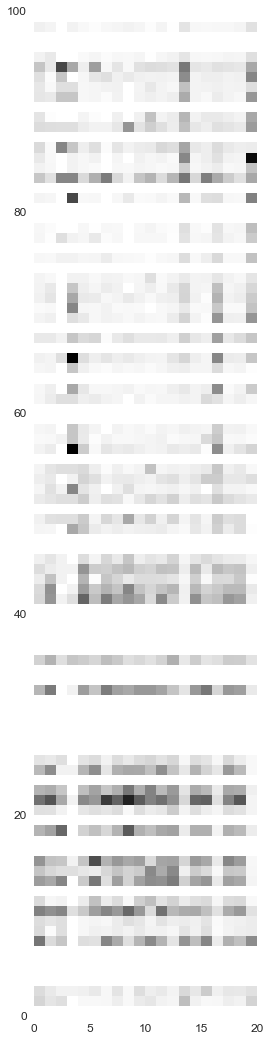

In [20]:
sns.set(rc={'figure.figsize': (4, 18),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
plt.pcolor(DifferentStateNumberModels[2].means_.T)
sns.set(rc={'figure.figsize': (18, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })

In [21]:
DifferentStateNumberSequenceLL = []
t1 = time.time();
for idx in range(len(NStates)) :
    DifferentStateNumberSequenceLL.append(np.zeros(NTest))
    
for idx in range(len(NStates)) :
    for i in range(NTest) :
        DifferentStateNumberSequenceLL[idx][i] = DifferentStateNumberModels[idx].score(BinSpikeRasters(SpikeRasters[0][NTrain + i]))
    t2 = time.time();
    print(t2-t1)
    
meanLL = []
for ll in DifferentStateNumberSequenceLL:
    meanLL.append(np.mean(ll))
    
print(meanLL)

0.514624834060669
1.0450019836425781
1.635638952255249
2.2790749073028564
[-34703.530535754777, -43819.153854386655, -85857.904189834691, -127453.96565718116]


In [22]:
np.sum(DifferentStateNumberModels[2].transmat_,axis=1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

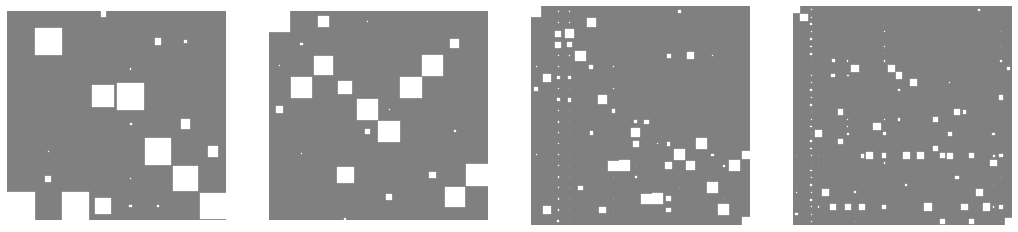

In [23]:
f, axarr = plt.subplots(1,len(NStates))

for idx,m in enumerate(DifferentStateNumberModels):
    plt.sca(axarr[idx])
    hinton(m.transmat_)



In [24]:
meanLL = []
for ll in DifferentStateNumberSequenceLL:
    meanLL.append(np.mean(ll))
print(meanLL)

[-34703.530535754777, -43819.153854386655, -85857.904189834691, -127453.96565718116]
